In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,Southern Province,Galle,Devata,112,Surath Chamara,18,New Loyed Pharmacy,1,Cosvate G Cream 15gm,2.0,258.75,295.0,0.0,0.0,517.50,2018,November,11,1,5,Thursday,16
1,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,Southern Province,Galle,Devata,112,Surath Chamara,18,New Loyed Pharmacy,96,Fixon Powder-15gm,1.0,206.20,235.0,0.0,0.0,206.20,2018,November,11,1,5,Thursday,16
2,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,Southern Province,Galle,Devata,112,Surath Chamara,18,New Loyed Pharmacy,125,Fusiway H-15g-1's,1.0,256.52,295.0,0.0,0.0,256.52,2018,November,11,1,5,Thursday,16
3,CSO011200326,94,2018-11-01 16:46:28.790,1768,Star Pharmacy,Southern Province,Galle,Devata,112,Surath Chamara,18,New Loyed Pharmacy,138,Travamax Syrup 100ml,3.0,261.40,298.0,0.0,0.0,784.20,2018,November,11,1,5,Thursday,16
4,CSO014800347,93,2018-11-01 17:36:07.053,1669,Arogya Pharmacy,Southern Province,Galle,Uragasmanhandiya,148,Dinesh Rasanga De Zoysa,15,Unique Enterprises,240,Metrogyl Gel 30mg,3.0,233.40,266.0,0.0,0.0,700.20,2018,November,11,1,5,Thursday,17


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product
Pro1_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 43]

In [7]:
Pro1_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
25,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,2,6,Friday,7
26,CSO011701378,54,2018-11-02 07:57:45.397,372,HEALTHY CARE PHARMACY,North Western Province,Puttalam,CHILAW,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,2,6,Friday,7
135,CSO011701379,54,2018-11-02 07:57:58.413,290,THALAHENA PHARMACY,Western Province,Gampaha,Negombo,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,2,6,Friday,7
136,CSO011701379,54,2018-11-02 07:57:58.413,290,THALAHENA PHARMACY,Western Province,Gampaha,Negombo,117,,2,The West Central Pharma (Pvt) Ltd.,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,2,6,Friday,7
256,IN0066000103,0,2018-11-02 12:05:39.753,2693,Sethsuwa Pharmacy,Southern Province,Hambantota,Angunukolapelessa,155,Priyashantha Niyagamage,14,Unichemist Distributor,43,Losatrust 50mg 100's,3.0,276.3,315.0,0.0,0.0,828.9,2018,November,11,2,6,Friday,12


In [8]:
 #get date from date time
Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date

<ipython-input-8-dd577f3fd3f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date


In [9]:
Pro1_inv_grp = Pro1_invoice_All.groupby("just_date").agg({'GrossValue':'sum'}).reset_index()

In [10]:
Pro1_inv_grp 

,just_date,GrossValue
0,2018-11-01,11052.0
1,2018-11-02,75429.9
2,2018-11-03,474130.8
3,2018-11-05,92007.9
4,2018-11-06,227947.5
...,...,...
416,2020-02-25,351499.0
417,2020-02-26,335849.0
418,2020-02-27,317695.0
419,2020-02-28,332719.0


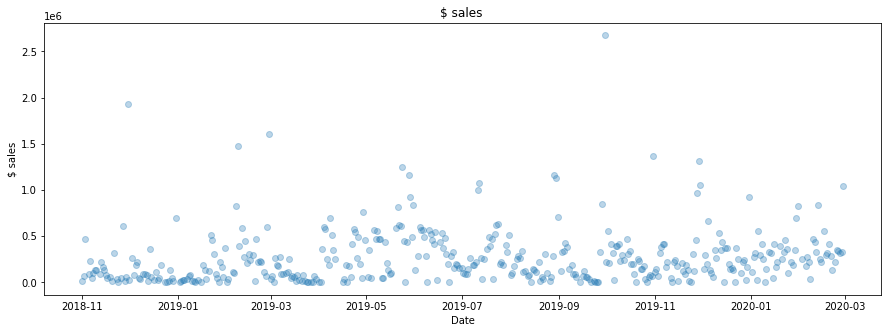

In [12]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

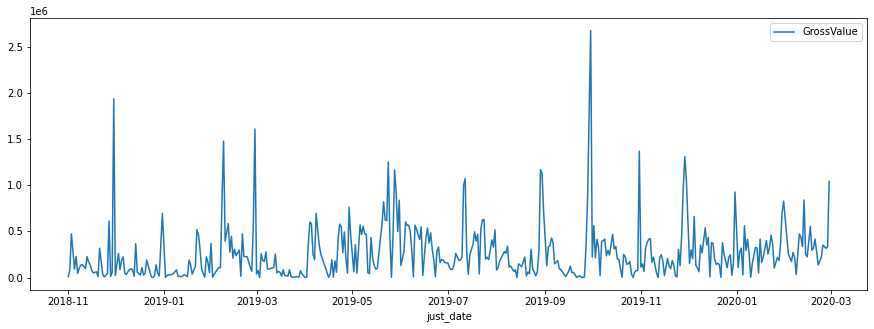

In [13]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

In [14]:
# remove z score > 3 
Pro1_inv_grp = Pro1_inv_grp[(np.abs(stats.zscore(Pro1_inv_grp["GrossValue"])) < 3)]

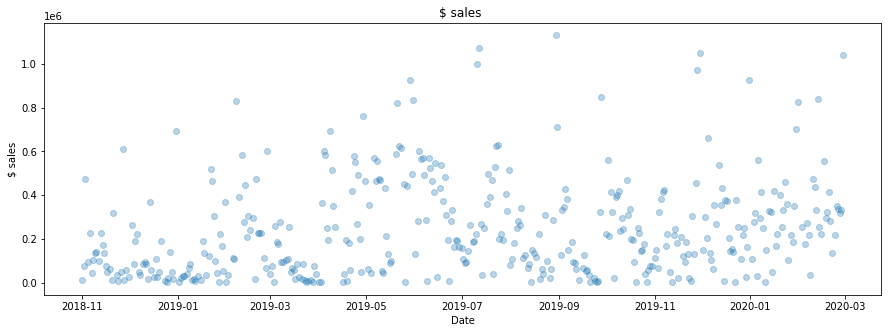

In [15]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

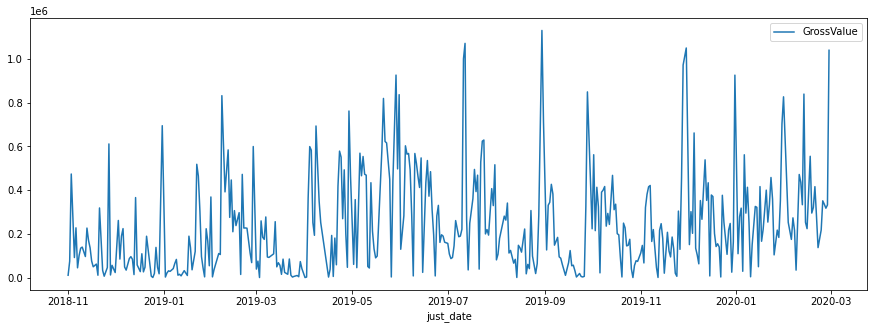

In [16]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

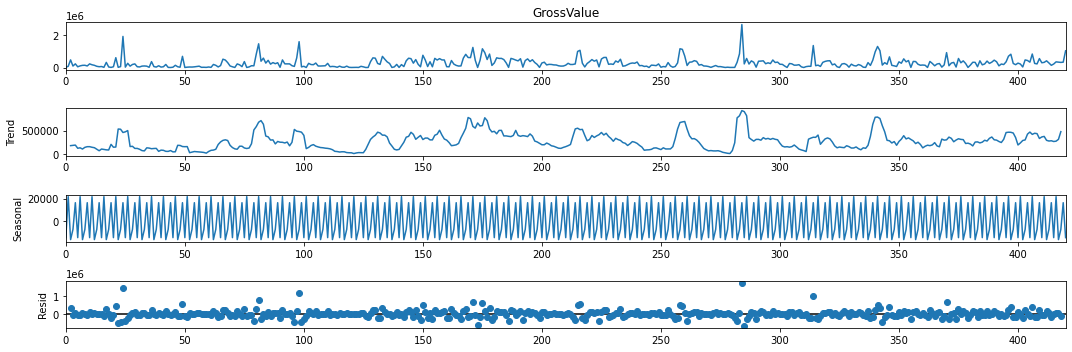

In [15]:
decomposition = seasonal_decompose(Pro1_inv_grp['GrossValue'], period =5)
decomposition.plot()
plt.show()

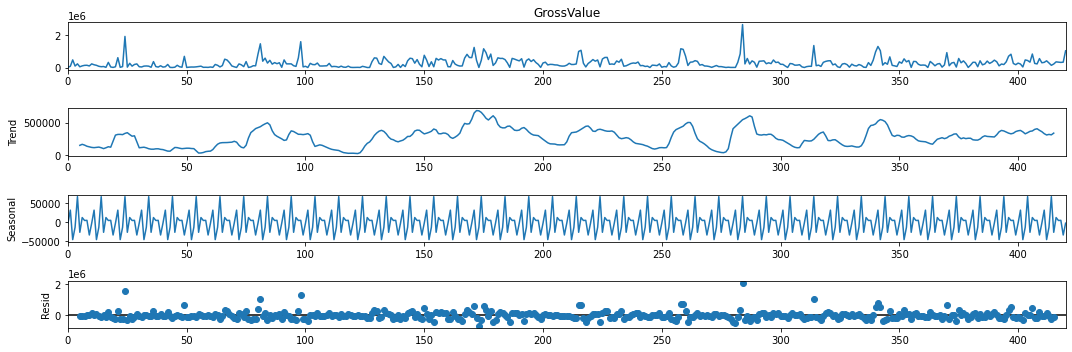

In [16]:
decomposition = seasonal_decompose(Pro1_inv_grp['GrossValue'], period =10)
decomposition.plot()
plt.show()

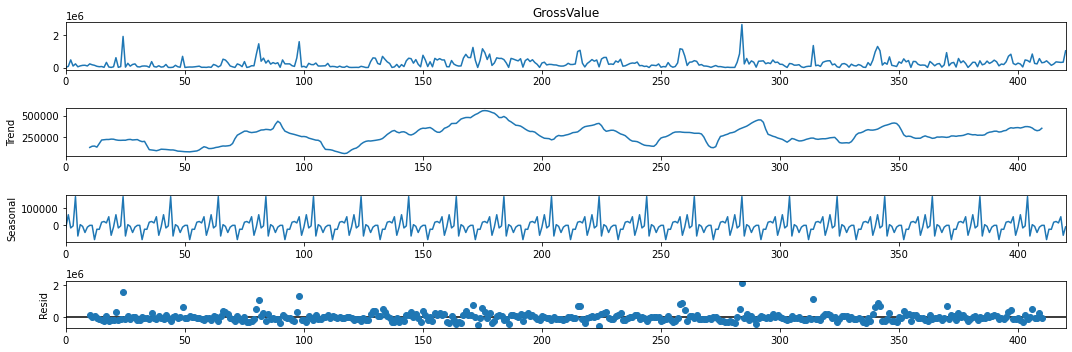

In [17]:
decomposition = seasonal_decompose(Pro1_inv_grp['GrossValue'], period =20)
decomposition.plot()
plt.show()

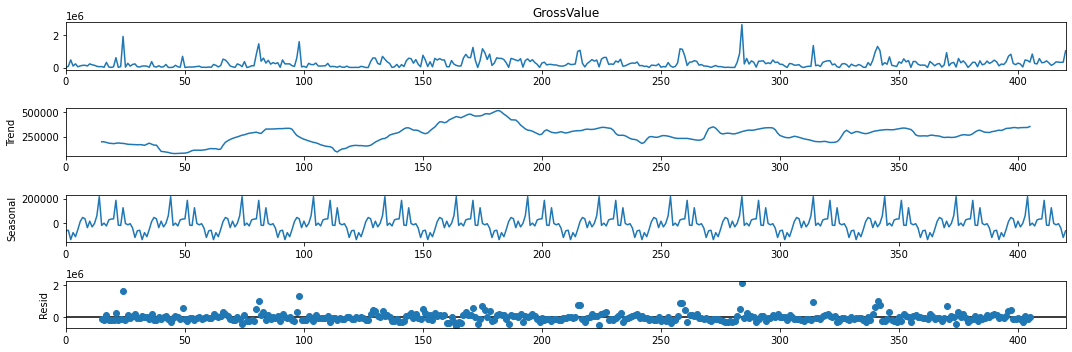

In [20]:
decomposition = seasonal_decompose(Pro1_inv_grp['GrossValue'], period =30)
decomposition.plot()
plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Pro1_inv_grp['GrossValue'])
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.448918e+01
p-value                        6.188767e-27
#Lags Used                     0.000000e+00
Number of Observations Used    4.200000e+02
Critical Value (1%)           -3.446016e+00
Critical Value (5%)           -2.868446e+00
Critical Value (10%)          -2.570449e+00
dtype: float64


In [22]:
 #fill in the missing dates
drange = pd.date_range(start=Pro1_inv_grp.just_date.min(), end=Pro1_inv_grp.just_date.max())
Pro1_inv_grp = Pro1_inv_grp.set_index('just_date').reindex(drange).rename_axis('just_date').reset_index()

In [23]:
#fill missing value with mean
Pro1_inv_grp.fillna({"GrossValue":Pro1_inv_grp['GrossValue'].mean().round(1)}, inplace=True)

In [24]:
Pro1_inv_grp = Pro1_inv_grp.sort_index()
Pro1_inv_grp.head(50)

,just_date,GrossValue
0,2018-11-01,11052.00
1,2018-11-02,75429.90
2,2018-11-03,474130.80
3,2018-11-04,269381.70
4,2018-11-05,92007.90
5,2018-11-06,227947.50
6,2018-11-07,45036.90
7,2018-11-08,101125.80
8,2018-11-09,134834.40
9,2018-11-10,139807.80


In [25]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] <= "2019-11-30"]
train = train.set_index('just_date')
test = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] > "2019-11-30"]
test = test.set_index('just_date')

In [26]:
from pmdarima import auto_arima
model = auto_arima(train.GrossValue, test='adf', trace=True)
results = model.fit(train.GrossValue)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=11034.267, Time=0.33 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11066.560, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=11032.616, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11040.535, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11299.365, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=11031.262, Time=0.03 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=11032.933, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=11033.190, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=11032.544, Time=0.05 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=11034.932, Time=0.11 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=11088.110, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.722 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  395
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5511.631
Date:                Thu, 17 Mar 2022   AIC                          11031.262
Time:                        23:02:28   BIC                          11047.178
Sample:                             0   HQIC                         11037.568
                                - 395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.689e+05   2.28e+04      7.397      0.000    1.24e+05    2.14e+05
ar.L1          0.2706      0.030      9.150      0.000       0.213       0.329
ar.L2          0.0923      0.041      2.228      0.026       0.011       0.174
sigma2      7.735e+10      0.125   6.17e+11      0.000    7.73e+10    7.73e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              6371.58
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             3.18
Prob(H) (two-sided):                  0.23   Kurtosis:                        21.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.5e+26. Standard errors may be unstable.
"""

In [27]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['GrossValue'],
                order=(2,0,0),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrossValue   No. Observations:                  395
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5541.055
Date:                Thu, 17 Mar 2022   AIC                          11088.110
Time:                        23:02:32   BIC                          11100.047
Sample:                    11-01-2018   HQIC                         11092.840
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4504      0.023     19.726      0.000       0.406       0.495
ar.L2          0.2770      0.034      8.123      0.000       0.210       0.344
sigma2      8.985e+10   2.91e-13   3.09e+23      0.000    8.98e+10    8.98e+10
===================================================================================
Ljung-Box (L1) (Q):                   5.12   Jarque-Bera (JB):              4052.63
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             2.29
Prob(H) (two-sided):                  0.48   Kurtosis:                        18.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.83e+39. Standard errors may be unstable.
"""

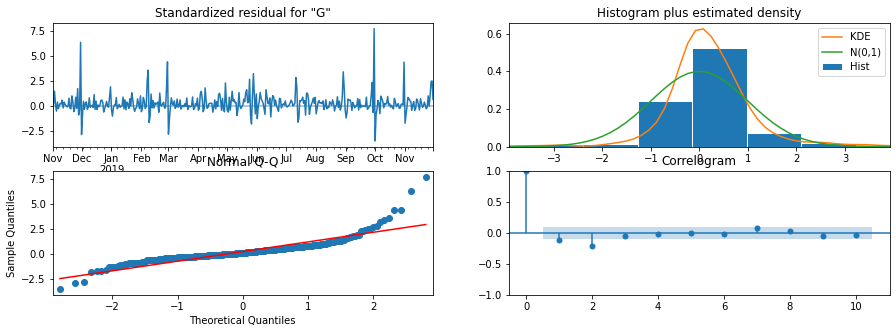

In [28]:
results.plot_diagnostics()
plt.show()

In [29]:
from sklearn.metrics import mean_squared_error
from math import sqrt
test_result = results.predict(start='2019-12-01', end='2020-02-29')
mse = mean_squared_error(test, test_result)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 348040.060059


#### Since this is quiet high value for RMSE the model is not best to predict.

In [30]:
test

,GrossValue
just_date,
2019-12-01,269381.7
2019-12-02,151179.0
2019-12-03,302045.0
2019-12-04,202824.0
2019-12-05,661995.0
...,...
2020-02-25,351499.0
2020-02-26,335849.0
2020-02-27,317695.0


In [31]:
test_result

2019-12-01    836022.430363
2019-12-02    667622.516721
2019-12-03    532329.313383
2019-12-04    424735.583004
2019-12-05    338790.442947
                  ...      
2020-02-25         0.003032
2020-02-26         0.002419
2020-02-27         0.001929
2020-02-28         0.001539
2020-02-29         0.001228
Freq: D, Name: predicted_mean, Length: 91, dtype: float64

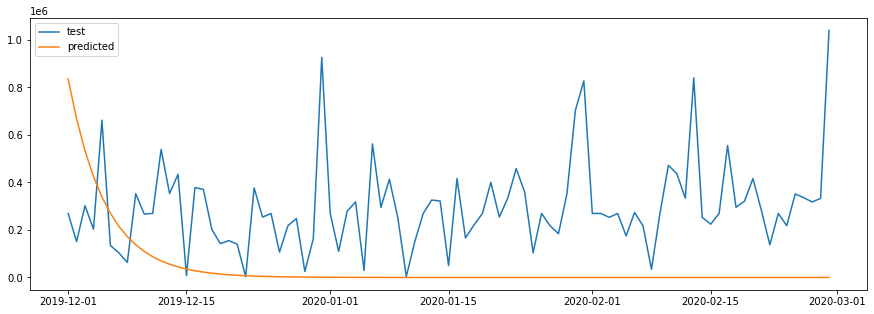

In [32]:
plt.plot(test)
plt.plot(test_result)
plt.legend(['test', 'predicted'])